In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from keras import backend as K
import cv2
import glob
import pandas as pd
from matplotlib import pyplot as plt
from math import ceil, floor
from tqdm import tqdm, tqdm_notebook
from skimage import morphology
from keras.utils.data_utils import get_file
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from imblearn.under_sampling import RandomUnderSampler
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential, Input, Model
from keras.layers import Conv2D, MaxPooling2D, MaxPooling1D, GlobalAveragePooling2D, ZeroPadding2D, Dense, Dropout, \
    Flatten, Input, LSTM, TimeDistributed
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import recall_score, roc_auc_score, f1_score, roc_curve, classification_report

Using TensorFlow backend.


In [2]:
base_data_dir = '../data/chest_xray/'

data_dir = base_data_dir + 'prepared/'
normal_dir = data_dir + 'normal/'
pneumonia_dir = data_dir + 'pneumonia/'
bacteria_dir = pneumonia_dir + 'bacteria/'
virus_dir = pneumonia_dir + 'virus/'
models_dir = './models/'
models_lungs_dir = models_dir + 'lung/'
models_binary_dir = models_dir + 'binary/'
models_categorical_dir = models_dir + 'categorical/'

for directory in [normal_dir, bacteria_dir, virus_dir, models_lungs_dir,
                  models_binary_dir, models_categorical_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

lung_segmentation_model_path = models_lungs_dir + 'lung_segmentation.hdf5'

In [3]:
normal_patterns = [
    base_data_dir + 'train/NORMAL/*.jpeg',
    base_data_dir + 'test/NORMAL/*.jpeg',
    base_data_dir + 'val/NORMAL/*.jpeg'
]

bacteria_patterns = [
    base_data_dir + 'train/PNEUMONIA/*bacteria*.jpeg',
    base_data_dir + 'test/PNEUMONIA/*bacteria*.jpeg',
    base_data_dir + 'val/PNEUMONIA/*bacteria*.jpeg'
]

virus_patterns = [
    base_data_dir + 'train/PNEUMONIA/*virus*.jpeg',
    base_data_dir + 'test/PNEUMONIA/*virus*.jpeg',
    base_data_dir + 'val/PNEUMONIA/*virus*.jpeg'
]

raw_normal = [item for sublist in [glob.glob(path) for path in normal_patterns] for item in sublist]
raw_bacteria = [item for sublist in [glob.glob(path) for path in bacteria_patterns] for item in sublist]
raw_virus = [item for sublist in [glob.glob(path) for path in virus_patterns] for item in sublist]

In [4]:
get_file('lung_segmentation.hdf5',
         'https://raw.githubusercontent.com/imlab-uiip/lung-segmentation-2d/master/trained_model.hdf5',
         cache_dir = models_dir, cache_subdir = 'lung')

UNet = load_model(lung_segmentation_model_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/Users/zhuvikin/anaconda3/envs/AIU_ML/lib/python3.7/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [5]:
def adjust_gamma(image, gamma = 1.0):
    invGamma = 1.0 / gamma
    table = np.array([
        ((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))


def adjust_contrast(image, contrast = 0):
    buf = image.copy()
    if contrast != 0:
        f = 131 * (contrast + 127) / (127 * (131 - contrast))
        alpha_c = f
        gamma_c = 127 * (1 - f)
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)
    return buf


def normalize_image(original, target_width = 256):
    im_shape = (256, 256)
    original_width = original.shape[1]
    original_height = original.shape[0]

    width_coeff = 256 / original_width
    height_coeff = 256 / original_height

    img = cv2.resize(original, im_shape, interpolation = cv2.INTER_AREA)
    img = cv2.equalizeHist(img)
    img = adjust_gamma(img, 0.75)
    img = img * 1.2
    img = np.clip(img, 0, 255)

    img2 = img.astype(float)
    img2 -= img2.mean()
    img2 /= img2.std()

    img2 = np.expand_dims(img2, -1)
    inp_shape = img2.shape
    pred = UNet.predict([[img2]])[..., 0].reshape(inp_shape[:2])
    pr = pred > 0.5
    pr = remove_small_regions(pr, 0.01 * np.prod(im_shape))
    pr = pr.astype(int)

    non_empty_columns = np.where(pr.max(axis = 0) > 0)[0]
    non_empty_rows = np.where(pr.max(axis = 1) > 0)[0]
    left = min(non_empty_columns) if len(non_empty_columns) > 0 else 0
    right = max(non_empty_columns) if len(non_empty_columns) > 0 else 256
    top = min(non_empty_rows) if len(non_empty_rows) > 0 else 0
    bottom = max(non_empty_rows) if len(non_empty_rows) > 0 else 256

    if right < 256 / 1.9:
        right = 256 - left

    if left > 256 / 2.1:
        left = 256 - right

    l = floor(left / width_coeff)
    t = floor(top / height_coeff)
    w = floor((right - left) / width_coeff)
    h = floor((bottom - top) / height_coeff)

    cropped = original[t:t + h, l:l + w]
    resized = cv2.resize(cropped, (target_width, target_width), interpolation = cv2.INTER_AREA)
    equalized = cv2.equalizeHist(resized)
    return equalized


def remove_small_regions(img, size):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

In [6]:
image_width = 256

i = 0
for path in tqdm_notebook(raw_normal):
    output_path = normal_dir + '{0:04d}.jpeg'.format(i)
    if not os.path.exists(output_path):
        img = cv2.imread(path, 0)
        normalized = normalize_image(img, image_width)
        cv2.imwrite(output_path, normalized)
    i += 1

i = 0
for path in tqdm_notebook(raw_bacteria + raw_virus):
    if 'bacteria' in path:
        output_path = bacteria_dir + '{0:04d}.jpeg'.format(i)
    else:
        output_path = virus_dir + '{0:04d}.jpeg'.format(i)
    if not os.path.exists(output_path):
        img = cv2.imread(path, 0)
        normalized = normalize_image(img, image_width)
        cv2.imwrite(output_path, normalized)
    i += 1

In [7]:
normal_df = pd.DataFrame(
    {'path': glob.glob(normal_dir + '*.jpeg'), 'normal': 1, 'bacteria': 0, 'virus': 0, 'target': 'Normal'})
bacteria_df = pd.DataFrame(
    {'path': glob.glob(bacteria_dir + '*.jpeg'), 'normal': 0, 'bacteria': 1, 'virus': 0, 'target': 'Pneumonia'})
virus_df = pd.DataFrame(
    {'path': glob.glob(virus_dir + '*.jpeg'), 'normal': 0, 'bacteria': 0, 'virus': 1, 'target': 'Pneumonia'})

# normal_df = pd.DataFrame(
#     {'path': raw_normal, 'normal': 1, 'bacteria': 0, 'virus': 0, 'target': 'Normal'})
# bacteria_df = pd.DataFrame(
#     {'path': raw_bacteria, 'normal': 0, 'bacteria': 1, 'virus': 0, 'target': 'Pneumonia'})
# virus_df = pd.DataFrame(
#     {'path': raw_virus, 'normal': 0, 'bacteria': 0, 'virus': 1, 'target': 'Pneumonia'})

dataset = pd.concat([normal_df, bacteria_df, virus_df])
dataset = dataset.sort_values('path')
dataset = dataset.sample(frac = 1, random_state = 0).reset_index(drop = True)

In [8]:
pd.set_option('max_colwidth', 100)
dataset.head(10)

,path,normal,bacteria,virus,target
0,../data/chest_xray/prepared/pneumonia/bacteria/2448.jpeg,0,1,0,Pneumonia
1,../data/chest_xray/prepared/pneumonia/bacteria/0207.jpeg,0,1,0,Pneumonia
2,../data/chest_xray/prepared/normal/0608.jpeg,1,0,0,Normal
3,../data/chest_xray/prepared/pneumonia/virus/4160.jpeg,0,0,1,Pneumonia
4,../data/chest_xray/prepared/pneumonia/virus/4161.jpeg,0,0,1,Pneumonia
5,../data/chest_xray/prepared/pneumonia/bacteria/1984.jpeg,0,1,0,Pneumonia
6,../data/chest_xray/prepared/normal/1045.jpeg,1,0,0,Normal
7,../data/chest_xray/prepared/pneumonia/virus/3815.jpeg,0,0,1,Pneumonia
8,../data/chest_xray/prepared/normal/0642.jpeg,1,0,0,Normal
9,../data/chest_xray/prepared/pneumonia/bacteria/1023.jpeg,0,1,0,Pneumonia


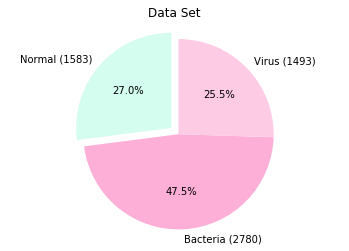

In [9]:
colors = ['#D4FCEF', '#FDAFD7', '#FECBE5']


def labels(normal_amount, bacteria_amount, virus_amount): return \
    'Normal ({0:d})'.format(normal_amount), \
    'Bacteria ({0:d})'.format(bacteria_amount), \
    'Virus ({0:d})'.format(virus_amount)


def sizes(normal_amount, bacteria_amount, virus_amount):
    total = normal_amount + bacteria_amount + virus_amount
    return [normal_amount / total, bacteria_amount / total, virus_amount / total]


fig1, ax1 = plt.subplots()
ax1.pie(sizes(normal_df.shape[0], bacteria_df.shape[0], virus_df.shape[0]),
        explode = (0.1, 0, 0), labels = labels(normal_df.shape[0], bacteria_df.shape[0], virus_df.shape[0]),
        autopct = '%1.1f%%', startangle = 90, colors = colors)
ax1.axis('equal')
ax1.title.set_text('Data Set')
plt.show()

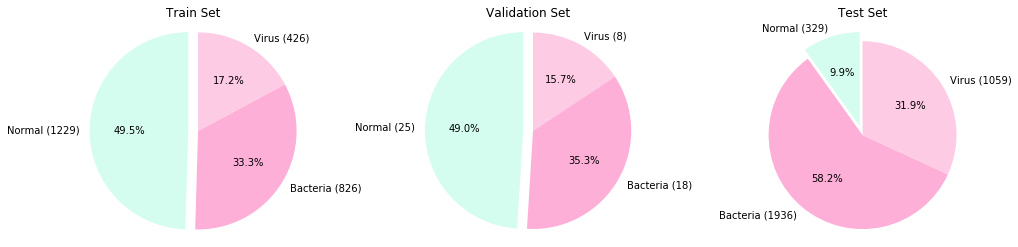

In [10]:
test_size = 0.2
validation_size = 0.02

sampler = RandomUnderSampler(random_state = 0)
X_balanced, _ = sampler.fit_resample(dataset[['path']].values, dataset[['target']].values)

balanced_dataset = pd.DataFrame({'path': X_balanced[:, 0]})
balanced_dataset = balanced_dataset.sample(frac = 1, random_state = 0).reset_index(drop = True)
balanced_dataset = pd.merge(balanced_dataset, dataset, on = 'path')
rest_dataset = pd.DataFrame(
    {'path': list(set(X_balanced[:, 0].tolist()).symmetric_difference(dataset[['path']].values[:, 0].tolist()))})
rest_dataset = rest_dataset.sample(frac = 1, random_state = 0).reset_index(drop = True)
rest_dataset = pd.merge(rest_dataset, dataset, on = 'path')

X_train_validation, X_test, y_train_validation, _ = train_test_split(
    balanced_dataset.path.values, balanced_dataset.target.values,
    test_size = test_size, random_state = 0)
X_train, X_validation, _, _ = train_test_split(
    X_train_validation, y_train_validation,
    test_size = validation_size, random_state = 3)

train_dataset = pd.merge(pd.DataFrame({'path': X_train}), dataset, on = 'path')
validation_dataset = pd.merge(pd.DataFrame({'path': X_validation}), dataset, on = 'path')
test_dataset = pd.concat([pd.merge(pd.DataFrame({'path': X_test}), dataset, on = 'path'), rest_dataset])

fig = plt.figure(figsize = (17, 4))
ax1 = fig.add_subplot(131)
ax1.pie(sizes(train_dataset.sum()[1], train_dataset.sum()[2], train_dataset.sum()[3]),
        explode = (0.1, 0, 0), labels = labels(train_dataset.sum()[1], train_dataset.sum()[2], train_dataset.sum()[3]),
        autopct = '%1.1f%%', startangle = 90, colors = colors)
ax1.axis('equal')
ax1.title.set_text('Train Set')

ax3 = fig.add_subplot(132)
ax3.pie(sizes(validation_dataset.sum()[1], validation_dataset.sum()[2], validation_dataset.sum()[3]),
        explode = (0.1, 0, 0),
        labels = labels(validation_dataset.sum()[1], validation_dataset.sum()[2], validation_dataset.sum()[3]),
        autopct = '%1.1f%%', startangle = 90, colors = colors)
ax3.axis('equal')
ax3.title.set_text('Validation Set')

ax2 = fig.add_subplot(133)
ax2.pie(sizes(test_dataset.sum()[1], test_dataset.sum()[2], test_dataset.sum()[3]),
        explode = (0.1, 0, 0), labels = labels(test_dataset.sum()[1], test_dataset.sum()[2], test_dataset.sum()[3]),
        autopct = '%1.1f%%', startangle = 90, colors = colors)
ax2.axis('equal')
ax2.title.set_text('Test Set')

plt.show()

In [11]:
imageGenerator = ImageDataGenerator(rescale = 1. / 255, horizontal_flip = True)
testGenerator = ImageDataGenerator(rescale = 1. / 255)

batch_size = 4
x_col = 'path'
y_col = 'target'
classes = ['Normal', 'Pneumonia']
mode = 'grayscale'
target_size = (150, 150)

print('Train generator:')
train_generator = imageGenerator.flow_from_dataframe(train_dataset, x_col = x_col, y_col = y_col,
                                                     seed = 0, target_size = target_size, batch_size = batch_size,
                                                     class_mode = 'binary', color_mode = mode)

print('\nValidation generator:')
validation_generator = testGenerator.flow_from_dataframe(validation_dataset, x_col = x_col, y_col = y_col,
                                                         seed = 0, target_size = target_size, batch_size = batch_size,
                                                         class_mode = 'binary', color_mode = mode, shuffle = False)

print('\nTest generator:')
test_generator = testGenerator.flow_from_dataframe(test_dataset, x_col = x_col, y_col = y_col,
                                                   seed = 0, target_size = target_size, batch_size = 1,
                                                   class_mode = 'binary', color_mode = mode, shuffle = False)

Train generator:
Found 2481 validated image filenames belonging to 2 classes.

Validation generator:
Found 51 validated image filenames belonging to 2 classes.

Test generator:
Found 3324 validated image filenames belonging to 2 classes.


In [12]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = train_generator.image_shape))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.15))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.15))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.15))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.15))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 74, 74, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
___________________________

In [13]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


model_check_point = ModelCheckpoint(
    models_binary_dir + 'pneumonia-{val_loss:.2f}-{val_acc:.2f}-{val_precision:.2f}-{val_recall:.2f}.hdf5',
    save_best_only = True, verbose = 1, monitor = 'val_acc', mode = 'max')

In [14]:
optimizer = Adam()

model.compile(loss = 'binary_crossentropy', optimizer = optimizer,
              metrics = ['accuracy', recall, precision])

train_generator.reset()
validation_generator.reset()
history = model.fit_generator(epochs = 100, shuffle = True, validation_data = validation_generator,
                              steps_per_epoch = 100, generator = train_generator,
                              validation_steps = validation_dataset.shape[0] * batch_size,
                              verbose = 1, callbacks = [model_check_point])

Epoch 1/50
100/100 [==============================] - 21s 206ms/step - loss: 1.0473 - acc: 0.7000 - recall: 0.6775 - precision: 0.6550 - val_loss: 0.4616 - val_acc: 0.7603 - val_recall: 0.5044 - val_precision: 0.6509

Epoch 00001: val_acc improved from -inf to 0.76030, saving model to ./models/binary/pneumonia-0.46-0.76-0.65-0.50.hdf5
Epoch 2/50
100/100 [==============================] - 21s 214ms/step - loss: 0.5868 - acc: 0.6850 - recall: 0.5050 - precision: 0.5175 - val_loss: 0.7003 - val_acc: 0.4913 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00

Epoch 00002: val_acc did not improve from 0.76030
Epoch 3/50
100/100 [==============================] - 25s 253ms/step - loss: 0.4371 - acc: 0.7350 - recall: 0.5542 - precision: 0.6958 - val_loss: 1.5764 - val_acc: 0.4913 - val_recall: 0.7183 - val_precision: 0.4850

Epoch 00003: val_acc did not improve from 0.76030
Epoch 4/50
100/100 [==============================] - 21s 205ms/step - loss: 0.5282 - acc: 0.6150 - recall: 0.6700 - pr

100/100 [==============================] - 21s 211ms/step - loss: 0.3099 - acc: 0.8650 - recall: 0.7417 - precision: 0.8350 - val_loss: 0.7854 - val_acc: 0.7250 - val_recall: 0.7183 - val_precision: 0.6437

Epoch 00029: val_acc did not improve from 0.86875
Epoch 30/50
100/100 [==============================] - 21s 213ms/step - loss: 0.2978 - acc: 0.8825 - recall: 0.7942 - precision: 0.8217 - val_loss: 0.9856 - val_acc: 0.7066 - val_recall: 0.7840 - val_precision: 0.6072

Epoch 00030: val_acc did not improve from 0.86875
Epoch 31/50
100/100 [==============================] - 21s 214ms/step - loss: 0.2803 - acc: 0.8800 - recall: 0.7450 - precision: 0.8300 - val_loss: 0.4946 - val_acc: 0.8250 - val_recall: 0.6825 - val_precision: 0.7117

Epoch 00031: val_acc did not improve from 0.86875
Epoch 32/50
100/100 [==============================] - 23s 232ms/step - loss: 0.3061 - acc: 0.8900 - recall: 0.7959 - precision: 0.8776 - val_loss: 0.3507 - val_acc: 0.8250 - val_recall: 0.7183 - val_preci

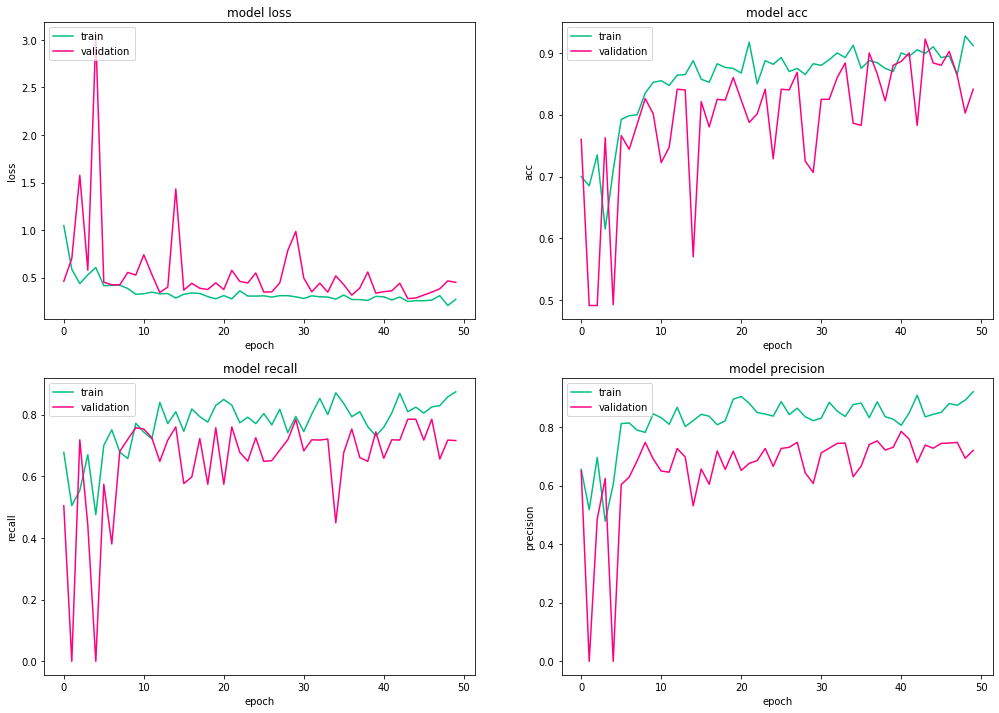

In [15]:
metrics = ['loss', 'acc', 'recall', 'precision']

fig = plt.figure(figsize = (17, 12))
for i, metric in enumerate(metrics):
    ax = plt.subplot(2, 2, i + 1)
    ax.set_facecolor('w')
    ax.grid(b = False)
    ax.plot(history.history[metric], color = '#00bf81')
    ax.plot(history.history['val_' + metric], color = '#ff0083')
    plt.title('model ' + metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')

plt.show()

In [20]:
binary_models = []
for model_path in glob.glob(models_binary_dir + 'pneumonia-*.hdf5'):
    name = os.path.basename(model_path)
    (prefix, sep, suffix) = name.rpartition('.')
    scores = list(map(lambda k: float(k), prefix.split('-')[1:]))
    binary_models.append([model_path] + scores)

binary_models = pd.DataFrame(binary_models, columns = ['path', 'loss', 'acc', 'precision', 'recall'])
best_binary_model_path = binary_models.sort_values('acc', ascending = False).path.iloc[0]

In [21]:
best_binary_model = load_model(best_binary_model_path, custom_objects = {
    'recall': recall,
    'precision': precision
})

In [22]:
test_generator.reset()
test_pred = model.predict_generator(test_generator, verbose = 1, steps = test_dataset.shape[0])

3324/3324 [==============================] - 25s 8ms/step


In [23]:
print(classification_report(test_generator.classes, np.rint(test_pred).astype(int).flatten().tolist()))

              precision    recall  f1-score   support

           0       0.64      0.93      0.76       329
           1       0.99      0.94      0.97      2995

    accuracy                           0.94      3324
   macro avg       0.82      0.94      0.86      3324
weighted avg       0.96      0.94      0.95      3324

